In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.feature as cfeature
from matplotlib import colors as c 
# import verde as vd
from scipy.interpolate import RegularGridInterpolator
import geopandas as gpd
from shapely.geometry import mapping, Polygon, Point
from shapely.ops import unary_union
from matplotlib.patches import Rectangle 
import glob

import processing as arp

ERROR 1: PROJ: proj_create_from_database: Open of /work/Marc.Prange/.conda/envs/work_python/share/proj failed


In [2]:
# Define a function to calculate distance between two (lat, lon) points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    distance = R * c
    return distance

In [3]:
grdc = xr.open_dataset(
    '/home/Marc.Prange/work/2024-04-03_20-55/GRDC-Daily.nc'
    )
grdc['dsch'] = (grdc.runoff_mean * 1000 / grdc.area / 1e6)

region = gpd.read_file('/home/Marc.Prange/work/2024-04-03_20-55/stationbasins.geojson')
grdc = grdc.isel(id=np.isin(grdc.id, region.grdc_no))
region = region.loc[np.isin(region.grdc_no, grdc.id)]
region_cmb_geometry = unary_union(region.geometry)
region_cmb_geometry
grdc

<xarray.Dataset>
Dimensions:              (time: 52890, id: 123)
Coordinates:
  * time                 (time) datetime64[ns] 1878-06-01 ... 2023-03-22
  * id                   (id) int32 4115080 4115081 4115082 ... 4215800 4215900
Data variables:
    runoff_mean          (time, id) float32 nan nan nan nan ... nan nan nan nan
    area                 (id) float32 ...
    country              (id) object ...
    geo_x                (id) float32 ...
    geo_y                (id) float32 ...
    geo_z                (id) float32 ...
    owneroforiginaldata  (id) object ...
    river_name           (id) object ...
    station_name         (id) object ...
    timezone             (id) float32 ...
    dsch                 (time, id) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    title:          Mean daily discharge (Q)
    Conventions:    CF-1.7
    references:     grdc.bafg.de
    institution:    GRDC
    history:        Download from GRDC Database, 03/04/2024
    missing_value:  -999.000

In [4]:
paths = [p for p in 
 glob.glob('/archive/Marc.Prange/na_data/c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020/'
           'c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020_na_*.nc') 
 if int(p[-7:-3]) in range(1990, 2020)]

model_data = xr.open_mfdataset(paths).load()
model_river_static = arp.sel_na(arp.lon_360_to_180(xr.open_dataset(
    '/archive/Ming.Zhao/awg/2022.03/c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020/gfdl.ncrc4-intel-prod-openmp/pp/river/'
    'river.static.nc')))
model_data['vol_discharge'] = model_data.rv_o_h2o * model_river_static.land_area / 1000
model_data['vol_runoff'] = model_data.mrro * model_river_static.land_area / 1000


In [5]:
paths = [p for p in 
 glob.glob('/archive/Marc.Prange/na_data/c192L33_am4p0_amip_HIRESMIP_nudge_wind_1day_p2K/'
           'c192L33_am4p0_amip_HIRESMIP_nudge_wind_1day_p2K_na_*.nc') 
 if int(p[-7:-3]) in range(1990, 2020)]

model_data_p2K = xr.open_mfdataset(paths).load()
model_data_p2K['vol_discharge'] = model_data_p2K.rv_o_h2o * model_river_static.land_area / 1000
model_data_p2K['vol_runoff'] = model_data_p2K.mrro * model_river_static.land_area / 1000

In [11]:
paths = [p for p in 
 glob.glob('/archive/Marc.Prange/na_data/c192_obs/'
           'c192_obs_na_*.nc') 
 if int(p[-7:-3]) in range(1990, 2020)]

era5_data = xr.open_mfdataset(paths).load()
era5_data

<xarray.Dataset>
Dimensions:    (time: 10957, bnds: 2, lon: 128, lat: 100)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2019-12-31
  * lon        (lon) float64 -139.7 -139.1 -138.4 ... -61.56 -60.94 -60.31
  * lat        (lat) float64 20.25 20.75 21.25 21.75 ... 68.25 68.75 69.25 69.75
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 1990-01-01 ... 2019-12-31T18:00:00
    prw        (time, lat, lon) float32 24.41 23.18 21.89 ... 1.61 1.623 1.673
    ivtx       (time, lat, lon) float32 -171.4 -167.4 -162.0 ... 16.43 16.25
    ivty       (time, lat, lon) float32 -46.64 -50.04 -51.85 ... -8.742 -8.288
    pr         (time, lat, lon) float64 8.681e-06 6.601e-06 ... 3.617e-06
    ar_shape   (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    ar_pr      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Tue Dec 13 10:40:09 2022: cdo timselmean,4 ERA5.1990010100-...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [51]:
model_gauge_dsch = [model_data.rv_o_h2o.interp(lat=lat, lon=lon, method='nearest') 
                    for lat, lon in zip(region.lat_org, region.long_org)]
model_gauge_vol_dsch = [model_data.vol_discharge.interp(lat=lat, lon=lon, method='nearest') 
                    for lat, lon in zip(region.lat_org, region.long_org)]
model_gauge_dsch = xr.Dataset(
    data_vars={
        'rv_o_h2o': (('id', 'time'), np.array(model_gauge_dsch)),
        'vol_discharge': (('id', 'time'), np.array(model_gauge_vol_dsch)),
        'lat': (('id'), [d.lat for d in model_gauge_dsch]),
        'lon': (('id'), [d.lon for d in model_gauge_dsch]),
        }, 
    coords={'id': grdc.id, 'time': model_data.time.values})

In [6]:
model_basin_mask = xr.DataArray(
    data=np.array([[region_cmb_geometry.contains(Point(lon, lat)) 
                    for lon in model_data.lon] 
                   for lat in model_data.lat]).squeeze(),
    coords=(model_data.lat, model_data.lon)
    )

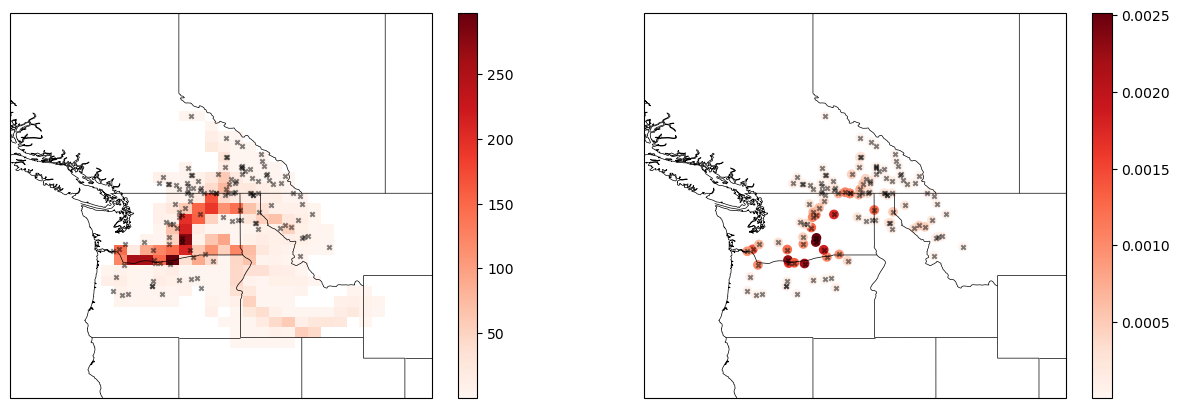

In [73]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
pc = ax1.pcolormesh(
    model_data.lon, model_data.lat, 
    model_data.isel(time=100).where(model_basin_mask).rv_o_h2o*86400,
    cmap='Reds'
    )
fig.colorbar(pc)
ax1.scatter(region.long_org, region.lat_org, marker='x', color='black', s=10, alpha=0.5)

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
s = ax2.scatter(
    model_gauge_dsch.lon, model_gauge_dsch.lat,
    c=model_gauge_dsch.rv_o_h2o.isel(time=100),
    cmap='Reds'
    )
ax2.scatter(region.long_org, region.lat_org, marker='x', color='black', s=10, alpha=0.5)
fig.colorbar(s)
for ax in [ax1, ax2]:
    ax.set_extent([region.long_org.min()-5, region.long_org.max()+5, region.lat_org.min()-5, region.lat_org.max()+5], crs=ccrs.PlateCarree())
    ax.coastlines("10m", linewidth=0.5)
    # axis.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='tab:blue', edgecolor='tab:blue', linewidth=0.5)
    # axis.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='tab:blue', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)

In [44]:
lat_fine = np.arange(model_data.lat.min(), model_data.lat.max()+0.1, 0.1)
lon_fine = np.arange(model_data.lon.min(), model_data.lon.max()+0.1, 0.1)

model_data_fine = model_data.interp({'lon': lon_fine, 'lat': lat_fine})

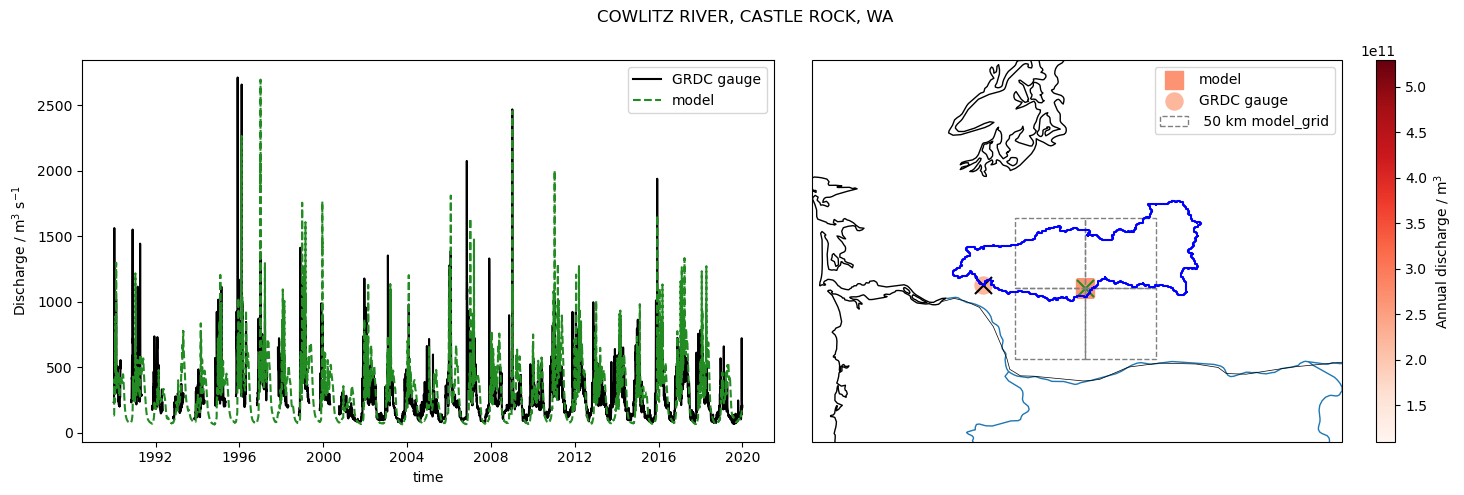

In [9]:
for i, basin in [list(region.iterrows())[0]]:
    model_basin_mask = xr.DataArray(
        data=np.array([[basin.geometry.contains(Point(lon, lat)) 
                        for lon in model_data.lon] 
                    for lat in model_data.lat]).squeeze(),
        coords=(model_data.lat, model_data.lon)
        )

    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(121)

    model_dsch = model_data.vol_discharge.where(model_basin_mask).dropna(dim='lon', how='all').dropna(dim='lat', how='all')
    # model_dsch_p2K = model_data_p2K.vol_discharge.where(model_basin_mask).dropna(dim='lon', how='all').dropna(dim='lat', how='all')
    model_dsch['dist_to_gauge'] = haversine(basin.lat_org, basin.long_org, model_dsch.lat, model_dsch.lon)
    model_time_mask = np.isin(model_dsch.time, grdc.time)
    obs_time_mask = np.isin(grdc.time, model_dsch.time)
    obs_dsch = grdc.runoff_mean.isel(time=obs_time_mask)
    dist_stack = model_dsch.stack(dist=('lat', 'lon'))
    if len(dist_stack.dist) == 0:
        print(f"No data points in basin {i}.")
        continue
    dist_stack = dist_stack.sortby(dist_stack.dist_to_gauge)
    nearest_lat, nearest_lon = dist_stack.dropna('dist').isel(dist=0).lat, dist_stack.dropna('dist').isel(dist=0).lon
    model_dsch_nearest = model_dsch.isel(time=model_time_mask).sel(lat=nearest_lat, lon=nearest_lon)
    # model_dsch_nearest_p2K = model_dsch_p2K.isel(time=model_time_mask).sel(lat=nearest_lat, lon=nearest_lon)
    dist_gauge_model = haversine(basin.lat_org, basin.long_org, model_dsch_nearest.lat, model_dsch_nearest.lon) 
    ax1.plot(
        obs_dsch.time, 
        obs_dsch.sel(id=basin.grdc_no), 
        color='black', label='GRDC gauge')
    # ax1.plot(
    #     model_dsch.time.isel(time=np.arange(0, 365)), 
    #     model_dsch.isel(time=np.arange(0, 365)).sum(['lat', 'lon']),
    #     color='red', ls='--', label='basin sum of model discharge')
    ax1.plot(
        model_dsch_nearest.time,
        model_dsch_nearest,
        color='forestgreen', ls='--', label='model')
    # ax1.plot(
    #     model_dsch_nearest_p2K.time,
    #     model_dsch_nearest_p2K,
    #     color='orangered', ls='--', label='model p2K')
    ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
    vmin = np.min([(model_dsch_nearest*86400).sum('time'), 
                   (obs_dsch.sel(id=basin.grdc_no)*86400).sum('time')])
    vmin = vmin / 2
    vmax = np.max([(model_dsch_nearest*86400).sum('time'), 
                   (obs_dsch.sel(id=basin.grdc_no)*86400).sum('time')])
    vmax = vmax * 2
    s1 = ax2.scatter(
        model_dsch_nearest.lon, model_dsch_nearest.lat, 
        c=(model_dsch_nearest*86400).sum('time'),
        cmap='Reds', s=150, marker='s', label='model',
        vmin=vmin, vmax=vmax
        )
    s2 = ax2.scatter(
        basin.long_org, basin.lat_org,
        c=(obs_dsch.sel(id=basin.grdc_no)*86400).sum('time'),
        cmap='Reds', s=150, marker='o', label='GRDC gauge',
        vmin=vmin, vmax=vmax)
    s3 = ax2.scatter(
        basin.long_org, basin.lat_org,
        color='black', marker='x', s=150
    )
    s3 = ax2.scatter(
        model_dsch_nearest.lon, model_dsch_nearest.lat,
        color='forestgreen', marker='x', s=150
    )
    fig.colorbar(s1, label='Annual discharge / m$^{3}$')
    xx, yy = basin.geometry.exterior.coords.xy
    ax2.plot(xx, yy, color='blue',)
    # ax2.text(
    #     0.5, 0.9, 
    #     f'distance(gauge-model):{np.round(dist_gauge_model.values, 2)} km', 
    #     transform=ax2.transAxes)
    Rec_list = [Rectangle(
        (model_dsch_nearest.lon+0.5*flon, 
         model_dsch_nearest.lat+0.5*flat), 
        0.5, 0.5, edgecolor='grey', ls='--', fill=False)
        for flon, flat in zip([0, 0, -1, -1], [0, -1, 0, -1])]
    Rec_list[-1].set_label(' 50 km model_grid')
                
    [ax2.add_patch(R) for R in Rec_list]
    ax2.legend()
    # ax1.set(title=f'Daily discharge {model_dsch_nearest["time.year"].values[0]}')
    # ax2.set(title=f'Total annual discharge {model_dsch_nearest["time.year"].values[0]}')
    fig.suptitle(f"{basin.river}, {basin.station}")

    ax1.legend()
    ax1.set(xlabel='time', ylabel='Discharge / m$^{3}$ s$^{-1}$')
    for ax in [ax2]:
        edge = 1
        ax.set_extent([np.min(xx)-edge, np.max(xx)+edge, np.min(yy)-edge, np.max(yy)+edge], crs=ccrs.PlateCarree())
        ax.coastlines("10m", linewidth=1)
        # axis.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='tab:blue', edgecolor='tab:blue', linewidth=0.5)
        ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='tab:blue', linewidth=1)
        ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)
        states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')
        ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)
    plt.tight_layout()

<xarray.DataArray ()>
array(inf)
Coordinates:
    lat            float64 46.25
    lon            float64 -122.2
    dist_to_gauge  float64 55.96
    dist           object (46.25, -122.18749999999997)

In [115]:
(model_pr*86400).max()

<xarray.DataArray 'prli' ()>
array(54.06636335)
Coordinates:
    lat            float64 49.25
    lon            float64 -119.1
    dist_to_gauge  float64 36.84
    dist           object (49.25, -119.0625)

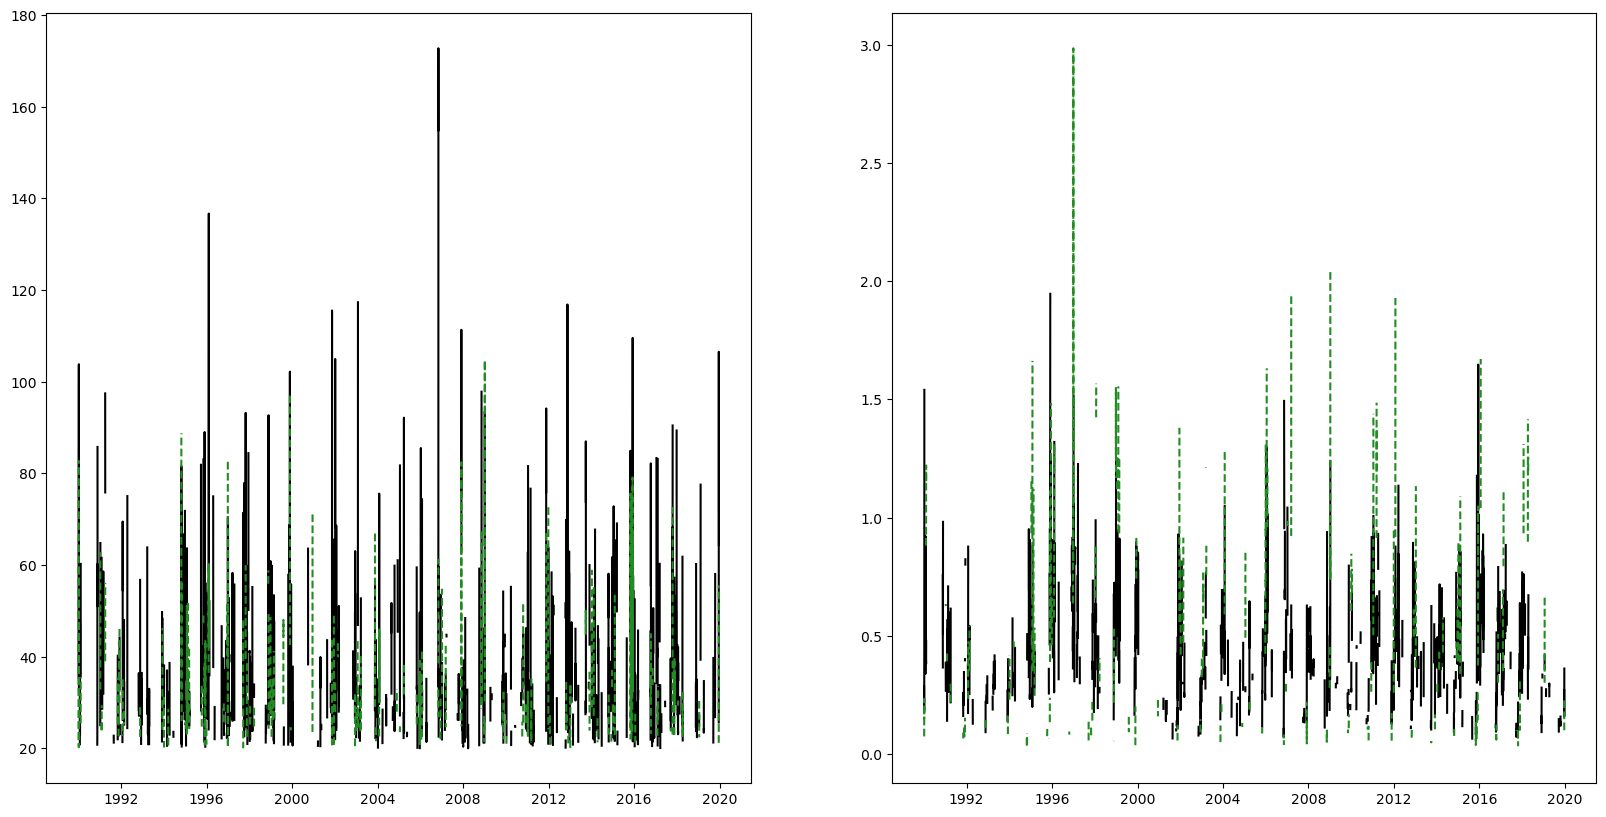

In [31]:
era5_pr = (era5_data.pr.sel(lat=nearest_lat, lon=nearest_lon, method='nearest'))
model_pr = (model_data.prli.sel(lat=nearest_lat, lon=nearest_lon))
era5_pr = era5_pr.where(era5_pr*86400>20)
model_pr = model_pr.where(model_pr*86400>20)

model_dsch_mass = (model_dsch_nearest*1000/model_river_static.land_area.sel(lat=nearest_lat, lon=nearest_lon))
obs_dsch_mass = obs_dsch.sel(id=basin.grdc_no) * 1000 / model_river_static.land_area.sel({'lat': nearest_lat, 'lon': nearest_lon})
# model_pr_p2K = (model_data_p2K.prsel(lat=nearest_lat, lon=nearest_lon)*86400)

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax1.plot(
    era5_pr.time,
    era5_pr*86400,
    color='black', label='model')
ax1.plot(
    model_pr.time,
    model_pr*86400 ,
    color='forestgreen', ls='--', label='model')
ax2 = fig.add_subplot(122)
ax2.plot(
    era5_pr.time,
    obs_dsch_mass/era5_pr,
    color='black', label='model')
ax2.plot(
    model_pr.time,
    model_dsch_mass / model_pr ,
    color='forestgreen', ls='--', label='model')
# ax2.set(ylim=[0, 1])
# ax1.plot(
#     model_pr_p2K.time,
#     model_pr_p2K,
#     color='orangered', ls='--', label='model p2K')

In [32]:
(model_dsch_mass / model_pr).mean()

<xarray.DataArray ()>
array(0.48808715, dtype=float32)
Coordinates:
    lat            float64 46.25
    lon            float64 -122.2
    dist_to_gauge  float64 55.96
    dist           object (46.25, -122.18749999999997)

[(0.0, 1.1)]

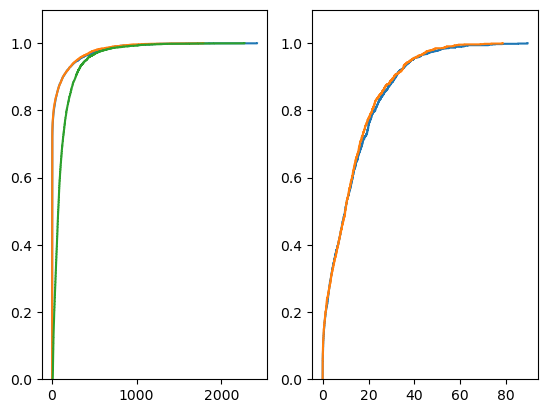

In [74]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.ecdf(model_dsch_nearest.sel(time=slice('2002-01-01', '2020-01-01')))#, bins=np.arange(0, 5000, 100))
ax.ecdf(model_dsch_nearest_p2K.sel(time=slice('2002-01-01', '2020-01-01')))#, bins=np.arange(0, 5000, 100))
ax.ecdf(obs_dsch.sel(id=basin.grdc_no).sel(time=slice('2002-01-01', '2020-01-01')))#, bins=np.arange(0, 5000, 100))
ax2 = fig.add_subplot(122)
ax2.ecdf(model_pr.sel(time=slice('2002-01-01', '2020-01-01')))#, bins=np.arange(0, 5000, 100))
ax2.ecdf(model_pr_p2K.sel(time=slice('2002-01-01', '2020-01-01')))#, bins=np.arange(0, 5000, 100))
# ax.ecdf(obs_dsch.sel(id=basin.grdc_no).sel(time=slice('2002-01-01', '2020-01-01')))
ax.set(ylim=[0, 1.1])
ax2.set(ylim=[0, 1.1])